In [1]:
import sys
sys.path.append('..')
import torch
import numpy as np
import lib

import os
#parametres 
data_set_name='mind'
device='cuda:4'# default device is cpu if device_ids=[] or None
tree_num=20
repeat_time=1
runtime=1# total 10 times
optimizer=lambda params:torch.optim.Adam(params,lr=1.0e-3,amsgrad=True)#,weight_decay=0.1)
has_processed_data=True
negative_num=None##if negative_num is None, compute the negative_num by N in trainer
topk=20
N=3#if negative_num is None, compute the negative_num by N in trainer
train_sample_seg_cnt=10#the training data is located in the train_sample_seg_cnt datafiles
parall=4
seq_len=70 # se_len-1 is the number of behaviours in all the windows
min_seq_len=15                           
test_user_num=6000# the number of user in test file
tree_learner_mode='jtm'


item_node_share_embedding=True
raw_data_file='./data/{}/{}.txt'.format(data_set_name,data_set_name)

data_file_prefix='./data/{}/runtime{}/'.format(data_set_name,runtime)
if not has_processed_data:
    if os.path.exists(data_file_prefix):
        pass
    else:
        os.makedirs(data_file_prefix)

train_instances_file=data_file_prefix+'train_instances'
test_instances_file=data_file_prefix+'test_instances'
validation_instances_file=data_file_prefix+'validation_instances'
kv_file=data_file_prefix+'kv.txt' # save the key vavlue (i.e. item_id:leaf_code)
embed_dim=24
result_prefix=data_file_prefix+'result_of_N_{}_tree_learning_mode_{}_share_embedding_{}_emb_dim{}/'.format(N,tree_learner_mode,item_node_share_embedding,embed_dim)
# the file path prefix to save the result


featrue_groups=[20,20,10,10,2,2,2,1,1,1]
assert sum(featrue_groups)==seq_len-1




#sample_num=100
training_batch_size=100
validation_batch_size=50
batch_gap_to_rebuild_tree=80000#float('inf')



eps=0.000001
if device!='cpu':
    torch.cuda.set_device(device)#the main gpu is device_ids[0]
    device='cuda'


In [2]:
def presision(result_list,gt_list,top_k):
    count=0.0
    for r,g in zip(result_list,gt_list):
       count+=len(set(r).intersection(set(g)))
    return count/(top_k*len(result_list))
def recall(result_list,gt_list):
    t=0.0
    for r,g in zip(result_list,gt_list):
        t+=1.0*len(set(r).intersection(set(g)))/len(g)
    return t/len(result_list)
def f_measure(result_list,gt_list,top_k,eps=1.0e-9):
    f=0.0
    for r,g in zip(result_list,gt_list):
        recc=1.0*len(set(r).intersection(set(g)))/len(g)
        pres=1.0*len(set(r).intersection(set(g)))/top_k
        if recc+pres<eps:
            continue
        f+=(2*recc*pres)/(recc+pres)
    return f/len(result_list)
def novelty(result_list,s_u,top_k):
    count=0.0
    for r,g in zip(result_list,s_u):
        count+=len(set(r)-set(g))
    return count/(top_k*len(result_list))

def hit_ratio(result_list,gt_list):
    intersetct_set=[len(set(r)&set(g)) for r,g in zip(result_list,gt_list)]
    return 1.0*sum(intersetct_set)/sum([len(gts) for gts in gt_list])

def NDCG(result_list,gt_list):
    t=0.0
    for re,gt in zip(result_list,gt_list):
        setgt=set(gt)
        indicator=np.asfarray([1 if r in setgt else 0 for r in re])
        sorted_indicator = np.ones(min(len(setgt), len(re)))
        if 1 in indicator:
            t+=np.sum(indicator / np.log2(1.0*np.arange(2,len(indicator)+ 2)))/\
               np.sum(sorted_indicator/np.log2(1.0*np.arange(2,len(sorted_indicator)+ 2)))
    return t/len(gt_list)

def MAP(result_list,gt_list,topk):
    t=0.0
    for re,gt in zip(result_list,gt_list):
        setgt=set(gt)
        indicator=np.asfarray([1 if r in setgt else 0 for r in re])
        t+=np.mean([indicator[:i].sum(-1)/i for i in range(1,topk+1)],axis=-1)
    return t/len(gt_list)

In [3]:
from lib.Generate_Data_and_Tree import _read,_gen_train_sample,_gen_test_sample,_init_tree,_gen_discriminator_samples
import gc
import numpy as np
if not has_processed_data: 
    behavior_dict, train_sample, test_sample,validation_sample = _read(raw_data_file,test_user_num)  # 20 is the test users
    # write the training instance into different train_sample_seg_cnt files， avoid that a file is too large
    # stat record the click frequency of each item
    # seq_len=20 min that 19 behaviors and one label
    stat = _gen_train_sample(train_sample, train_instances_file,test_sample=test_sample,validation_sample=validation_sample,
                                                    train_sample_seg_cnt=train_sample_seg_cnt,
                                                    parall=parall, seq_len=seq_len, min_seq_len=min_seq_len)
    _gen_test_sample(test_sample, test_instances_file, seq_len=seq_len,min_seq_len=min_seq_len)
    _gen_test_sample(validation_sample, validation_instances_file, seq_len=seq_len,min_seq_len=min_seq_len)
    
    #_gen_discriminator_samples(train_sample,discriminator_instances_file, train_sample_seg_cnt=train_sample_seg_cnt,
    #                                                parall=parall, seq_len=seq_len, min_seq_len=min_seq_len)
    ids, codes = _init_tree(train_sample, test_sample,validation_sample, stat, kv_file=kv_file)
    del behavior_dict
    del train_sample
    del test_sample
    del stat
    gc.collect()

else:
    ids=[]
    codes=[]
    assert kv_file is not None
    with open(kv_file) as f:
        while True:
            line=f.readline()
            if line:
                id_code=line.split('::')
                ids.append(int(id_code[0]))
                codes.append(int(id_code[1]))
            else:
                break
    ids=np.array(ids,dtype=np.int32)
    codes=np.array(codes,dtype=np.int32)
print('min item id is {}, max item id is {}'.format(ids.min(),ids.max()))
print('min leaf node code is {}, max leaf node code is {}'.format(codes.min(), codes.max()))

ids_list,codes_list=[],[]
for _ in range(tree_num):
    ids_list.append(ids)
    codes_list.append(codes)
#print(ids_list[0])
item_num=len(ids_list[0])
print('item number is {}'.format(item_num))

min item id is 0, max item id is 7128
min leaf node code is 8191, max leaf node code is 16381
item number is 7129


In [4]:
from pandas import DataFrame
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

from lib.generate_training_batches import Train_instance
train_instances=Train_instance(parall=parall)
training_batch_generator=train_instances.training_batches(train_instances_file,train_sample_seg_cnt,batchsize=training_batch_size)
validation_batch_generator=train_instances.validation_batches(validation_instances_file,batchsize=validation_batch_size)
test_instances=train_instances.read_test_instances_file(test_instances_file)
training_instance_index_pair=train_instances.get_item_instance_pair_index(train_instances_file,train_sample_seg_cnt)#

item num is 7129


In [5]:
from lib.trainer import TrainModel
train_model=TrainModel(ids,codes,
                      embed_dim=embed_dim,
                      feature_groups=featrue_groups,
                      all_training_instance=train_instances.training_data,
                      item_user_pair_dict=training_instance_index_pair,
                      parall=parall, 
                      optimizer=optimizer,
                      negative_num=negative_num,
                      N=N,
                      tree_learner_mode=tree_learner_mode,
                      item_node_share_embedding=item_node_share_embedding,
                      device=device,
                     )

#print(train_model.tmd_model.device)
print(train_model.network_model)
#print(train_model.tmd_model.linear_part_0)
#for name,para in train_model.tmd_model.named_parameters():
#    print(name)


Tree 0,node number is 15320, tree height is 13
Network(
  (linearparts): ModuleList(
    (0): LinearLayer(
      (fc): Linear(in_features=264, out_features=128, bias=True)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (active_op): PReLU(num_parameters=1)
    )
    (1): LinearLayer(
      (fc): Linear(in_features=128, out_features=64, bias=True)
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (active_op): PReLU(num_parameters=1)
    )
    (2): LinearLayer(
      (fc): Linear(in_features=64, out_features=24, bias=True)
      (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (active_op): PReLU(num_parameters=1)
    )
    (3): LinearLayer(
      (fc): Linear(in_features=24, out_features=2, bias=True)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (active_op): PReLU(num_parameters=1)
    )
  )
  (ac

In [6]:
from pandas import DataFrame
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values
loss_history,dev_precision_history,dev_recall_history,dev_f_measure_history,dev_novelty_history=[],[],[],[],[]
total_precision_history,total_recall_history,total_f_measure_history,total_novelty_history=[],[],[],[]
dev_precision_each_result,dev_reall_each_result=[],[]
if os.path.exists(result_prefix):
    pass
    #filenames = os.listdir(result_prefix)
    #for filename in filenames:
    #    os.remove(result_prefix+filename)
else:
    os.makedirs(result_prefix)
print('tree number is {}'.format(tree_num))

tree number is 20


In [9]:

for (batch_x,batch_y) in training_batch_generator:
    loss=train_model.update_network_model(batch_x,batch_y)
    loss_history.append(loss.item())
    
    if train_model.batch_num%5000==0:
        train_model.network_model.eval()
        bs=50
        bs_count=(len(test_instances)-1)//bs+1
        all_result=np.zeros((len(test_instances),topk),dtype=np.int32)


        for i in range(bs_count):
            bs_user=test_instances[i*bs:(i+1)*bs]
            all_result[i*bs:(i+1)*bs]=train_model.predict(bs_user,100,topk,forest=False)
        resutl_history=all_result.tolist()
        total_precision_history.append(presision(resutl_history,train_instances.test_labels,topk))
        total_recall_history.append(recall(resutl_history,train_instances.test_labels))
        total_f_measure_history.append(f_measure(resutl_history,train_instances.test_labels,topk))
        total_novelty_history.append(novelty(resutl_history,test_instances.tolist(),topk))
        train_model.network_model.train()
            
    if train_model.batch_num% 100 == 0:
        #print('tree num {}'.format(len(train_model.tree_list)))jupyter
        ###start to test
        train_model.network_model.eval()
        validation_batch,validation_index=validation_batch_generator.__next__()
        gt_history=[train_instances.validation_labels[i.item()] for i in validation_index]
        resutl_history=train_model.predict(validation_batch,100,topk,forest=False).tolist()
        dev_precision_history.append(presision(resutl_history,gt_history,topk))
        dev_recall_history.append(recall(resutl_history,gt_history))
        dev_f_measure_history.append(f_measure(resutl_history,gt_history,topk))
        dev_novelty_history.append(novelty(resutl_history,validation_batch.tolist(),topk))
        
        train_model.network_model.train()
        #######
            

            
        clear_output(True)
        plt.figure(figsize=[18, 12])
        plt.subplot(2, 3, 1)
        plt.title('train loss over time'); plt.grid();
        plt.plot(moving_average(loss_history, span=50))
        plt.scatter(range(len(loss_history)), loss_history, alpha=0.1)

        plt.subplot(2, 3, 2)
        plt.title('dev presision over time'); plt.grid();
        plt.plot(moving_average(dev_precision_history, span=50))
        plt.scatter(range(len(dev_precision_history)), dev_precision_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_precision_history)) + 1), total_precision_history, c='r')
        
        plt.subplot(2, 3, 3)
        plt.title('dev recall over time'); plt.grid();
        plt.plot(moving_average(dev_recall_history, span=10))
        plt.scatter(range(len(dev_recall_history)), dev_recall_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_recall_history)) + 1), total_recall_history, c='r')
        
        plt.subplot(2, 3, 4)
        plt.title('dev f-measure over time'); plt.grid();
        plt.plot(moving_average(dev_f_measure_history, span=10))
        plt.scatter(range(len(dev_f_measure_history)), dev_f_measure_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_f_measure_history)) + 1), total_f_measure_history, c='r')
        
        plt.subplot(2, 3, 5)
        plt.title('dev novelty over time'); plt.grid();
        plt.plot(moving_average(dev_novelty_history, span=10))
        plt.scatter(range(len(dev_novelty_history)), dev_novelty_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_novelty_history)) + 1), total_novelty_history, c='r')

        
        # plt.subplot(2, 3, 6)
        # plt.title('each tree\'s recall over time'); plt.grid();
        # for i in range(len(train_model.tree_list)):
        #     res=[r[i] for r in dev_reall_each_result]
        #     plt.plot(moving_average(res, span=10),label='tree {}'.format(i))
        #     plt.scatter(range(len(res)), res, alpha=0.1)
        # plt.legend(loc='lower right')
        plt.show()
        
        print("step=%i, mean_loss=%.3f, time=%.3f" % 
              (len(loss_history), np.mean(loss_history[-100:]),1.0))
        print('_' * 100)
        print('tree mumber is {}'.format(len(train_model.tree_list)))

    if train_model.batch_num>=batch_gap_to_rebuild_tree and len(train_model.tree_list)<=tree_num:#batch_gap_to_rebuild_tree 
        print('hh')
        model_path=result_prefix+"{}_tree_{}_network_model.pth".format(tree_learner_mode,len(train_model.tree_list))
        if os.path.exists(model_path):
            os.remove(model_path)
        torch.save(train_model.network_model,model_path)
        
        tree_path=result_prefix+"{}_tree_{}_tree.txt".format(tree_learner_mode,len(train_model.tree_list))
        with open(tree_path,'w') as f:
            for item_id,code in train_model.tree.item_id_leaf_code.items():
                line=str(item_id)+"::"+str(code)+'\n'
                f.write(line)
        if len(train_model.tree_list)<tree_num:
            train_model.update_tree(d=7)
            each_result,dev_reall_each_result=[],[]

    if train_model.batch_num>=batch_gap_to_rebuild_tree and len(train_model.tree_list)>=tree_num:
        loss_path=result_prefix+"loss.txt"
        dev_precision_path=result_prefix+"dev_precision.txt"
        total_precision_path=result_prefix+"total_precision.txt"
        
        dev_recall_path=result_prefix+"dev_recall.txt"
        total_recall_path=result_prefix+"total_recall.txt"
        
        dev_f_measure_path=result_prefix+"dev_f_measure.txt"
        total_f_measure_path=result_prefix+"total_f_measure.txt"
        dev_novelty_path=result_prefix+"dev_novelty.txt"
        total_novelty_path= result_prefix+"total_novelty.txt"
        
        np.savetxt(loss_path,np.array(loss_history),fmt='%f')
        
        np.savetxt(dev_precision_path,np.array(dev_precision_history),fmt='%f')
        np.savetxt(total_precision_path,np.array(total_precision_history),fmt='%f')
        
        np.savetxt(dev_recall_path,np.array(dev_recall_history),fmt='%f')
        np.savetxt(total_recall_path,np.array(total_recall_history),fmt='%f')
        
        np.savetxt(dev_f_measure_path,np.array(dev_f_measure_history),fmt='%f')
        np.savetxt(total_f_measure_path,np.array(total_f_measure_history),fmt='%f')
        
        np.savetxt(dev_novelty_path,np.array(dev_novelty_history),fmt='%f')
        np.savetxt(total_novelty_path,np.array(total_novelty_history),fmt='%f')
        
        print('over')
        print(train_model.batch_num,len(train_model.tree_list),tree_num)

        break



../lib/trainer.py:131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  codes = (codes-1)//2


hh
over
80001 20 20


In [7]:
model_path=result_prefix+"{}_tree_{}_network_model.pth".format(tree_learner_mode,1)
train_model.network_model.load_state_dict(torch.load(model_path,map_location=torch.device(device)).state_dict())

<All keys matched successfully>

In [11]:

import time

resutl_history=[]
topk=20
beam_size=200
train_model.network_model.eval()
bs=100
bs_count=(len(test_instances)-1)//bs+1
all_result=np.zeros((len(test_instances),topk),dtype=np.int32)

#tot=0.0

st=time.time()
for i in range(bs_count):
    bs_user=test_instances[i*bs:(i+1)*bs]
#     torch.cuda.empty_cache()
#     time.sleep(1.0)
#     st=time.time()
    all_result[i*bs:(i+1)*bs]=train_model.predict(bs_user,beam_size,topk,forest=False)
    #tot+=time.time()-st
print('cost time {:.4f}s'.format(time.time()-st))
#print('cost time {:.4f}s'.format(tot))
train_model.network_model.train()

print(all_result.shape)


all_result=all_result[:,::-1]
print(all_result.shape)
# multi_tree_result.append(deepcopy(all_result))
k=20
pre=presision(all_result[:,:k].tolist(),train_instances.test_labels,k)
rec=recall(all_result[:,:k].tolist(),train_instances.test_labels)
f_mea=f_measure(all_result[:,:k].tolist(),train_instances.test_labels,k)
# nove=novelty(all_result[:,:k].tolist(),test_instances.tolist(),k)
# hr=hit_ratio(all_result[:,:k].tolist(),train_instances.test_labels)
# ndcg=NDCG(all_result[:,:k].tolist(),train_instances.test_labels)
# map_=MAP(all_result[:,:k].tolist(),train_instances.test_labels,k)
print('{:.4f},{:.4f},{:.4f}'.format(pre,rec,f_mea))

cost time 6.9492s
(3400, 20)
(3400, 20)
0.2730,0.1141,0.1420


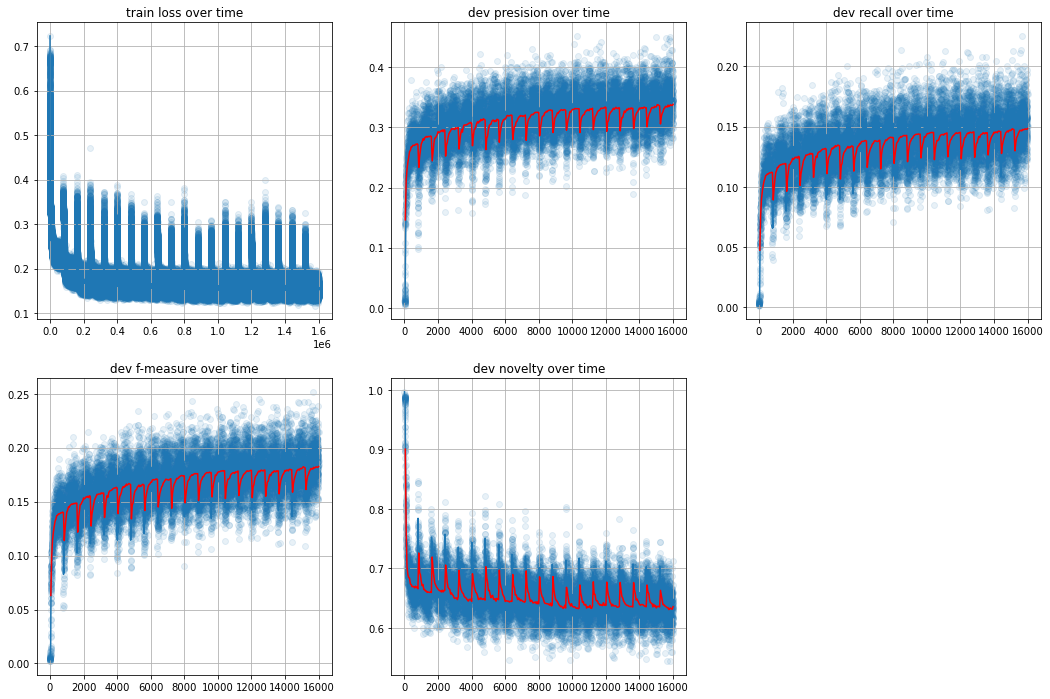

In [10]:



clear_output(True)
plt.figure(figsize=[18, 12])
plt.subplot(2, 3, 1)
plt.title('train loss over time'); plt.grid();
plt.plot(moving_average(loss_history, span=50))
plt.scatter(range(len(loss_history)), loss_history, alpha=0.1)

plt.subplot(2, 3, 2)
plt.title('dev presision over time'); plt.grid();
plt.plot(moving_average(dev_precision_history, span=50))
plt.scatter(range(len(dev_precision_history)), dev_precision_history, alpha=0.1)
plt.plot(50*(np.arange(len(total_precision_history)) + 1), total_precision_history, c='r')

plt.subplot(2, 3, 3)
plt.title('dev recall over time'); plt.grid();
plt.plot(moving_average(dev_recall_history, span=10))
plt.scatter(range(len(dev_recall_history)), dev_recall_history, alpha=0.1)
plt.plot(50*(np.arange(len(total_recall_history)) + 1), total_recall_history, c='r')

plt.subplot(2, 3, 4)
plt.title('dev f-measure over time'); plt.grid();
plt.plot(moving_average(dev_f_measure_history, span=10))
plt.scatter(range(len(dev_f_measure_history)), dev_f_measure_history, alpha=0.1)
plt.plot(50*(np.arange(len(total_f_measure_history)) + 1), total_f_measure_history, c='r')

plt.subplot(2, 3, 5)
plt.title('dev novelty over time'); plt.grid();
plt.plot(moving_average(dev_novelty_history, span=10))
plt.scatter(range(len(dev_novelty_history)), dev_novelty_history, alpha=0.1)
plt.plot(50*(np.arange(len(total_novelty_history)) + 1), total_novelty_history, c='r')


# plt.subplot(2, 3, 6)
# plt.title('each tree\'s recall over time'); plt.grid();
# for i in range(len(train_model.tree_list)):
#     res=[r[i] for r in dev_reall_each_result]
#     plt.plot(moving_average(res, span=10),label='tree {}'.format(i))
#     plt.scatter(range(len(res)), res, alpha=0.1)
# plt.legend(loc='lower right')
plt.show()
